In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'
from setup import *

Extracting data from ../Data/behavior_free_swimming.tar.gz...
Extracting models from ../Models/hmms_20240125.tar.gz...
Extracting models from ../Models/longtrajectories_20240202.tar.gz...


# Figure

## Panel : P(b) vs Temp

In [3]:
# getting P(b) for Markov Chain from threhsolded data
n_rep = 100
frac = 0.5

P_BOUTS_mc = np.empty( (len(TEMPS), 3, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    X = load_sequences(DATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    inds = np.arange(len(bouts))
    fracN = int(frac*len(bouts))
    Pb = []
    for r in range(n_rep):
        np.random.shuffle(inds)
        Pb.append(MC.bout_proba([bouts[i] for i in inds[:fracN]], n_state=3))
    Pb = np.c_[Pb]
    P_BOUTS_mc[t,:,1] = Pb.mean(axis=0)
    P_BOUTS_mc[t,:,2] = Pb.ptp(axis=0)/2
    P_BOUTS_mc[t,:,0] = MC.bout_proba(bouts)

In [4]:
# getting P(b) for HMM 3-state
P_BOUTS_hmm = np.empty( (len(TEMPS), 2, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    Ts = load_transmat_multi(MODELPATH, "g3", temp)
    Pb = np.c_[[MC.steady_state(T) for T in Ts]]
    P_BOUTS_hmm[t,:,1] = Pb.mean(axis=0)[:2]
    P_BOUTS_hmm[t,:,2] = Pb.ptp(axis=0)[:2]/2
    T = load_transmat(MODELPATH, "g3", temp)
    P_BOUTS_hmm[t,:,0] = MC.steady_state(T)[:2]

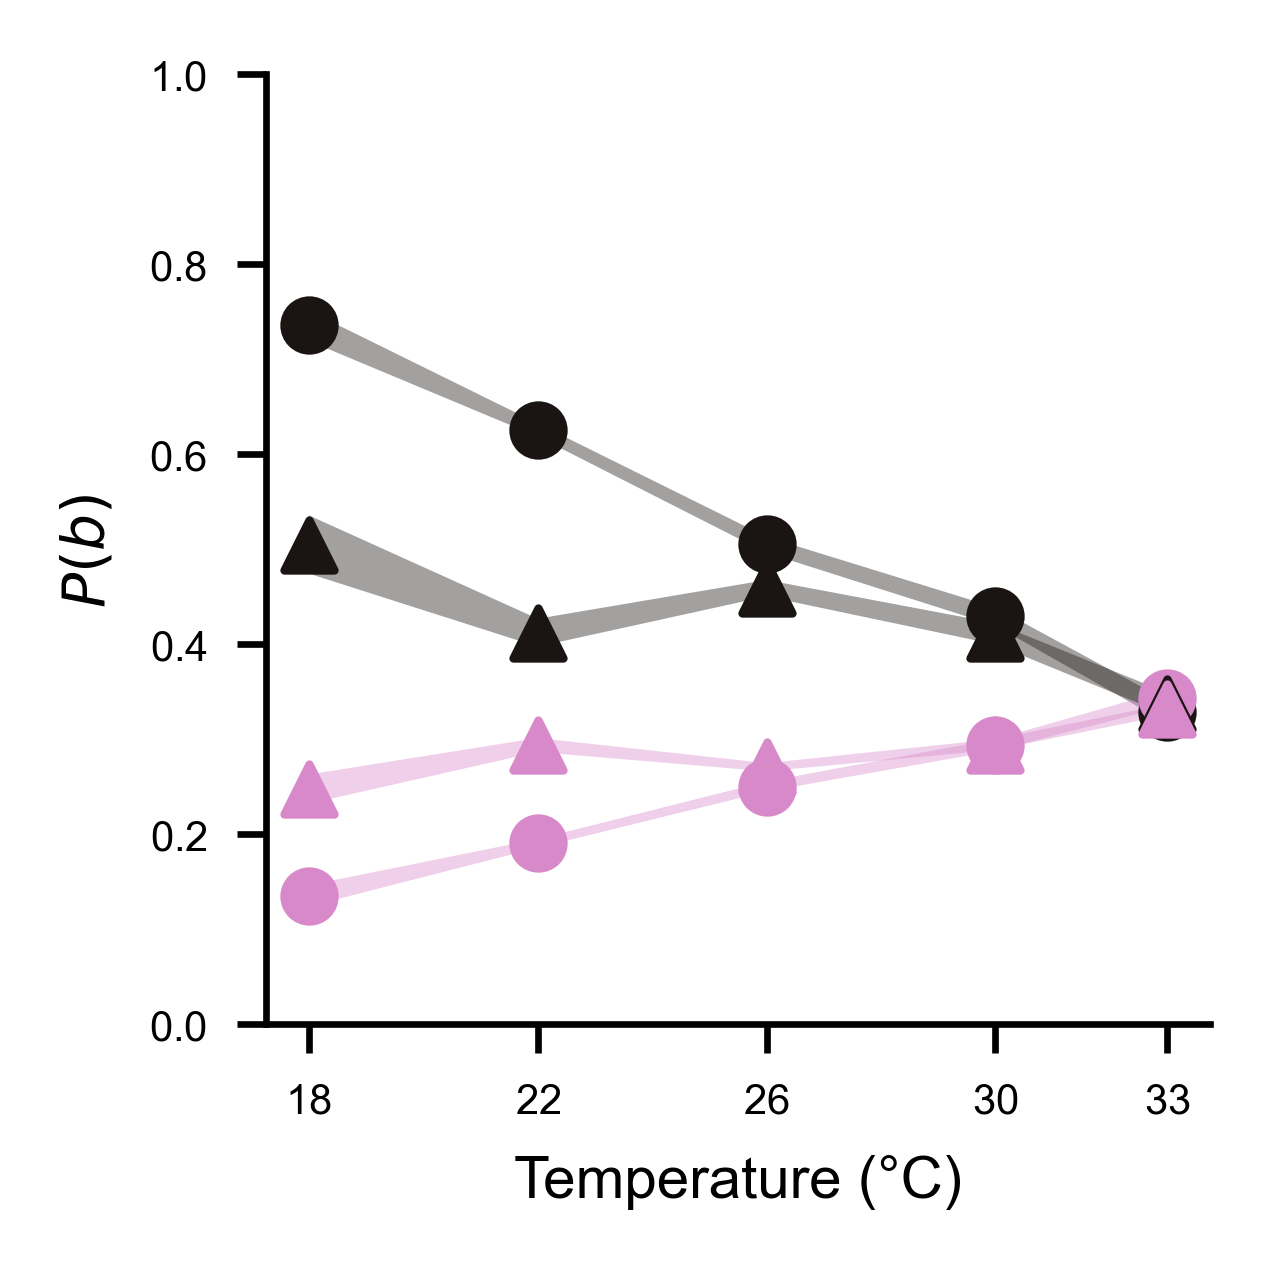

In [6]:
fig, ax = plt.subplots()

ax.scatter(TEMPS, P_BOUTS_mc[:,0,0], marker="o", color=FLR_colors[0],zorder=100)
ax.fill_between(
    TEMPS, 
    P_BOUTS_mc[:,0,1]+P_BOUTS_mc[:,0,2], 
    P_BOUTS_mc[:,0,1]-P_BOUTS_mc[:,0,2], 
    color=FLR_colors[0], edgecolor=None, alpha=0.4, zorder=0
)
ax.scatter(TEMPS, P_BOUTS_mc[:,1,0], marker="o", color=FLR_colors[2], zorder=100)
ax.fill_between(
    TEMPS, 
    P_BOUTS_mc[:,1,1]+P_BOUTS_mc[:,1,2], 
    P_BOUTS_mc[:,1,1]-P_BOUTS_mc[:,1,2], 
    color=FLR_colors[2], edgecolor=None, alpha=0.4, zorder=0
)

ax.scatter(TEMPS, P_BOUTS_hmm[:,0,0], marker="^", color=FLR_colors[0],zorder=101)
ax.fill_between(
    TEMPS, 
    P_BOUTS_hmm[:,0,1]+P_BOUTS_hmm[:,0,2], 
    P_BOUTS_hmm[:,0,1]-P_BOUTS_hmm[:,0,2], 
    color=FLR_colors[0], edgecolor=None, alpha=0.4, zorder=1
)
ax.scatter(TEMPS, P_BOUTS_hmm[:,1,0], marker="^", color=FLR_colors[2], zorder=101)
ax.fill_between(
    TEMPS, 
    P_BOUTS_hmm[:,1,1]+P_BOUTS_hmm[:,1,2], 
    P_BOUTS_hmm[:,1,1]-P_BOUTS_hmm[:,1,2], 
    color=FLR_colors[2], edgecolor=None, alpha=0.4, zorder=1
)

ax.set_ylim(0,1)
ax.set_xticks(TEMPS)
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel(r"$P(b)$")
#ax.legend()

fig.savefig("panels/Fig3/Pb.svg")

## Panel P(b|b)/P(b)

In [11]:
def transition_FLR_to_FT(T3):
    P3 = MC.steady_state(T3)
    P2 = np.array([P3[0], 1-P3[0]])
    T2 = np.array([
        [ T3[0,0]                        ,  T3[0,1] + T3[0,2] ],
        [ (T3[0,1] + T3[0,2])*P2[0]/P2[1],  T3[1:,1:].sum(axis=1).mean() ]
    ])
    return P2, T2

In [12]:
# getting P(b|b)/P(b) for Markov Chain from threhsolded data
n_rep = 100
frac = 0.5

P_bbb_mc = np.empty( (len(TEMPS), 2, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    X = load_sequences(DATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    bouts = [np.where(bout==2,1,bout) for bout in bouts]
    inds = np.arange(len(bouts))
    fracN = int(frac*len(bouts))
    Pb, T = [], []
    for r in range(n_rep):
        np.random.shuffle(inds)
        Pb.append(MC.bout_proba([bouts[i] for i in inds[:fracN]], n_state=2))
        T.append(MC.bout_transitions([bouts[i] for i in inds[:fracN]], n_state=2))
    Pb = np.c_[Pb]
    T = np.c_[T]
    Pbbb = T[:,[0,1],[0,1]] / Pb
    P_bbb_mc[t,:,1] = Pbbb.mean(axis=0)
    P_bbb_mc[t,:,2] = Pbbb.ptp(axis=0)/2
    P_bbb_mc[t,:,0] = MC.bout_transitions(bouts, n_state=2)[[0,1], [0,1]] / MC.bout_proba(bouts, n_state=2)

In [13]:
# getting P(b) and P(b|b) for HMM3
n_rep = 100
frac = 0.5

P_bbb_hmm = np.empty( (len(TEMPS), 2, 3) ) # ( temp x bout_type x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    Ts = load_transmat_multi(MODELPATH, "g3", temp)
    Pb, T = [], []
    for TT in Ts:
        pp,tt = transition_FLR_to_FT(TT)
        Pb.append(pp)
        T.append(tt)
    Pb = np.c_[Pb]
    T = np.c_[T]
    Pbbb = T[:,[0,1],[0,1]] / Pb
    P_bbb_hmm[t,:,1] = Pbbb.mean(axis=0)
    P_bbb_hmm[t,:,2] = Pbbb.ptp(axis=0)/2

    T = load_transmat(MODELPATH, "g3", temp)
    Pb = MC.steady_state(T)
    P2, T2 = transition_FLR_to_FT(T)
    P_bbb_hmm[t,:,0] = T2[[0,1], [0,1]] / P2
    

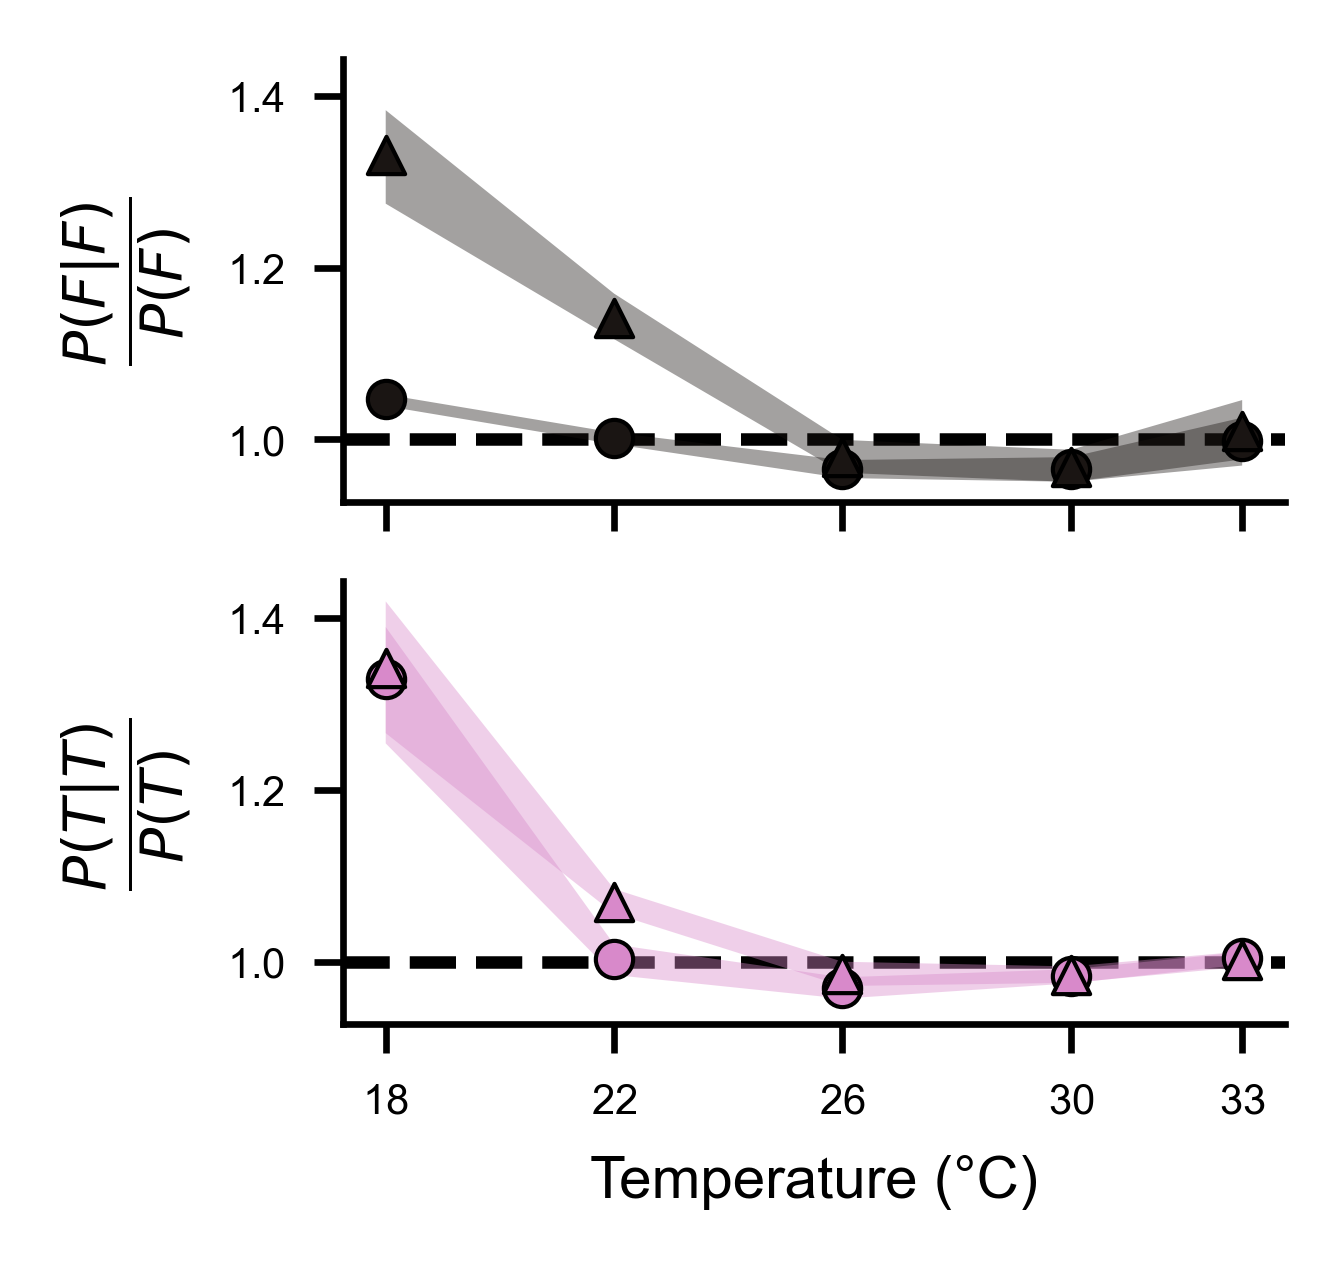

In [15]:
fig, axs = plt.subplots(figsize=(2.125,2), nrows=2, sharex=True, sharey=True)
ax1, ax2 = axs

# MC
ax1.scatter(
    TEMPS, P_bbb_mc[:,0,0], 
    marker="o", facecolor=FLR_colors[0], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax1.fill_between(
    TEMPS, 
    P_bbb_mc[:,0,1]+P_bbb_mc[:,0,2], 
    P_bbb_mc[:,0,1]-P_bbb_mc[:,0,2], 
    color=FLR_colors[0], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

ax2.scatter(
    TEMPS, P_bbb_mc[:,1,0], 
    marker="o", facecolor=FLR_colors[2], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax2.fill_between(
    TEMPS, 
    P_bbb_mc[:,1,1]+P_bbb_mc[:,1,2], 
    P_bbb_mc[:,1,1]-P_bbb_mc[:,1,2], 
    color=FLR_colors[2], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

# HMM
ax1.scatter(
    TEMPS, P_bbb_hmm[:,0,0], 
    marker="^", facecolor=FLR_colors[0], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax1.fill_between(
    TEMPS, 
    P_bbb_hmm[:,0,1]+P_bbb_hmm[:,0,2], 
    P_bbb_hmm[:,0,1]-P_bbb_hmm[:,0,2], 
    color=FLR_colors[0], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

ax2.scatter(
    TEMPS, P_bbb_hmm[:,1,0], 
    marker="^", facecolor=FLR_colors[2], 
    edgecolor="k", s=20, linewidth=0.5, zorder=2
)
ax2.fill_between(
    TEMPS, 
    P_bbb_hmm[:,1,1]+P_bbb_hmm[:,1,2], 
    P_bbb_hmm[:,1,1]-P_bbb_hmm[:,1,2], 
    color=FLR_colors[2], alpha=0.4, zorder=1,
    edgecolor=None, linewidth=0.5,
)

ax1.axhline(1, linestyle="--", color="k", zorder=0)
ax2.axhline(1, linestyle="--", color="k", zorder=0)
ax2.set_xticks(TEMPS)
ax2.set_xlabel("Temperature (°C)")
ax1.set_ylabel(r"$\dfrac{P(F|F)}{P(F)}$")
ax2.set_ylabel(r"$\dfrac{P(T|T)}{P(T)}$");

fig.savefig("panels/Fig3/Pbbb.svg")

## Panel : P(n+1|n) vs Temp

In [7]:
# getting T for Markov Chain from threhsolded data
n_rep = 100
frac = 0.5

T_mc = np.empty( (len(TEMPS), 3, 3, 3) ) # ( temp x bn x bn+1 x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    X = load_sequences(DATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)

    T_mc[t,:,:,0] = MC.bout_transitions(bouts)
    
    inds = np.arange(len(bouts))
    fracN = int(frac*len(bouts))
    Ts = []
    for r in range(n_rep):
        np.random.shuffle(inds)
        Ts.append(MC.bout_transitions([bouts[i] for i in inds[:fracN]], n_state=3))
    Ts = np.c_[Ts]
    T_mc[t,:,:,1] = Ts.mean(axis=0)
    T_mc[t,:,:,2] = Ts.ptp(axis=0)/2

In [8]:
# getting T for HMM 3-state
T_hmm = np.empty( (len(TEMPS), 3, 3, 3) ) # ( temp x bn x bn+1 x [alldataset, mean, std] )
for t,temp in enumerate(TEMPS):
    T_hmm[t,:,:,0] = load_transmat(MODELPATH, "g3", temp)
    
    Ts = load_transmat_multi(MODELPATH, "g3", temp)
    T_hmm[t,:,:,1] = Ts.mean(axis=0)
    T_hmm[t,:,:,2] = Ts.ptp(axis=0)/2

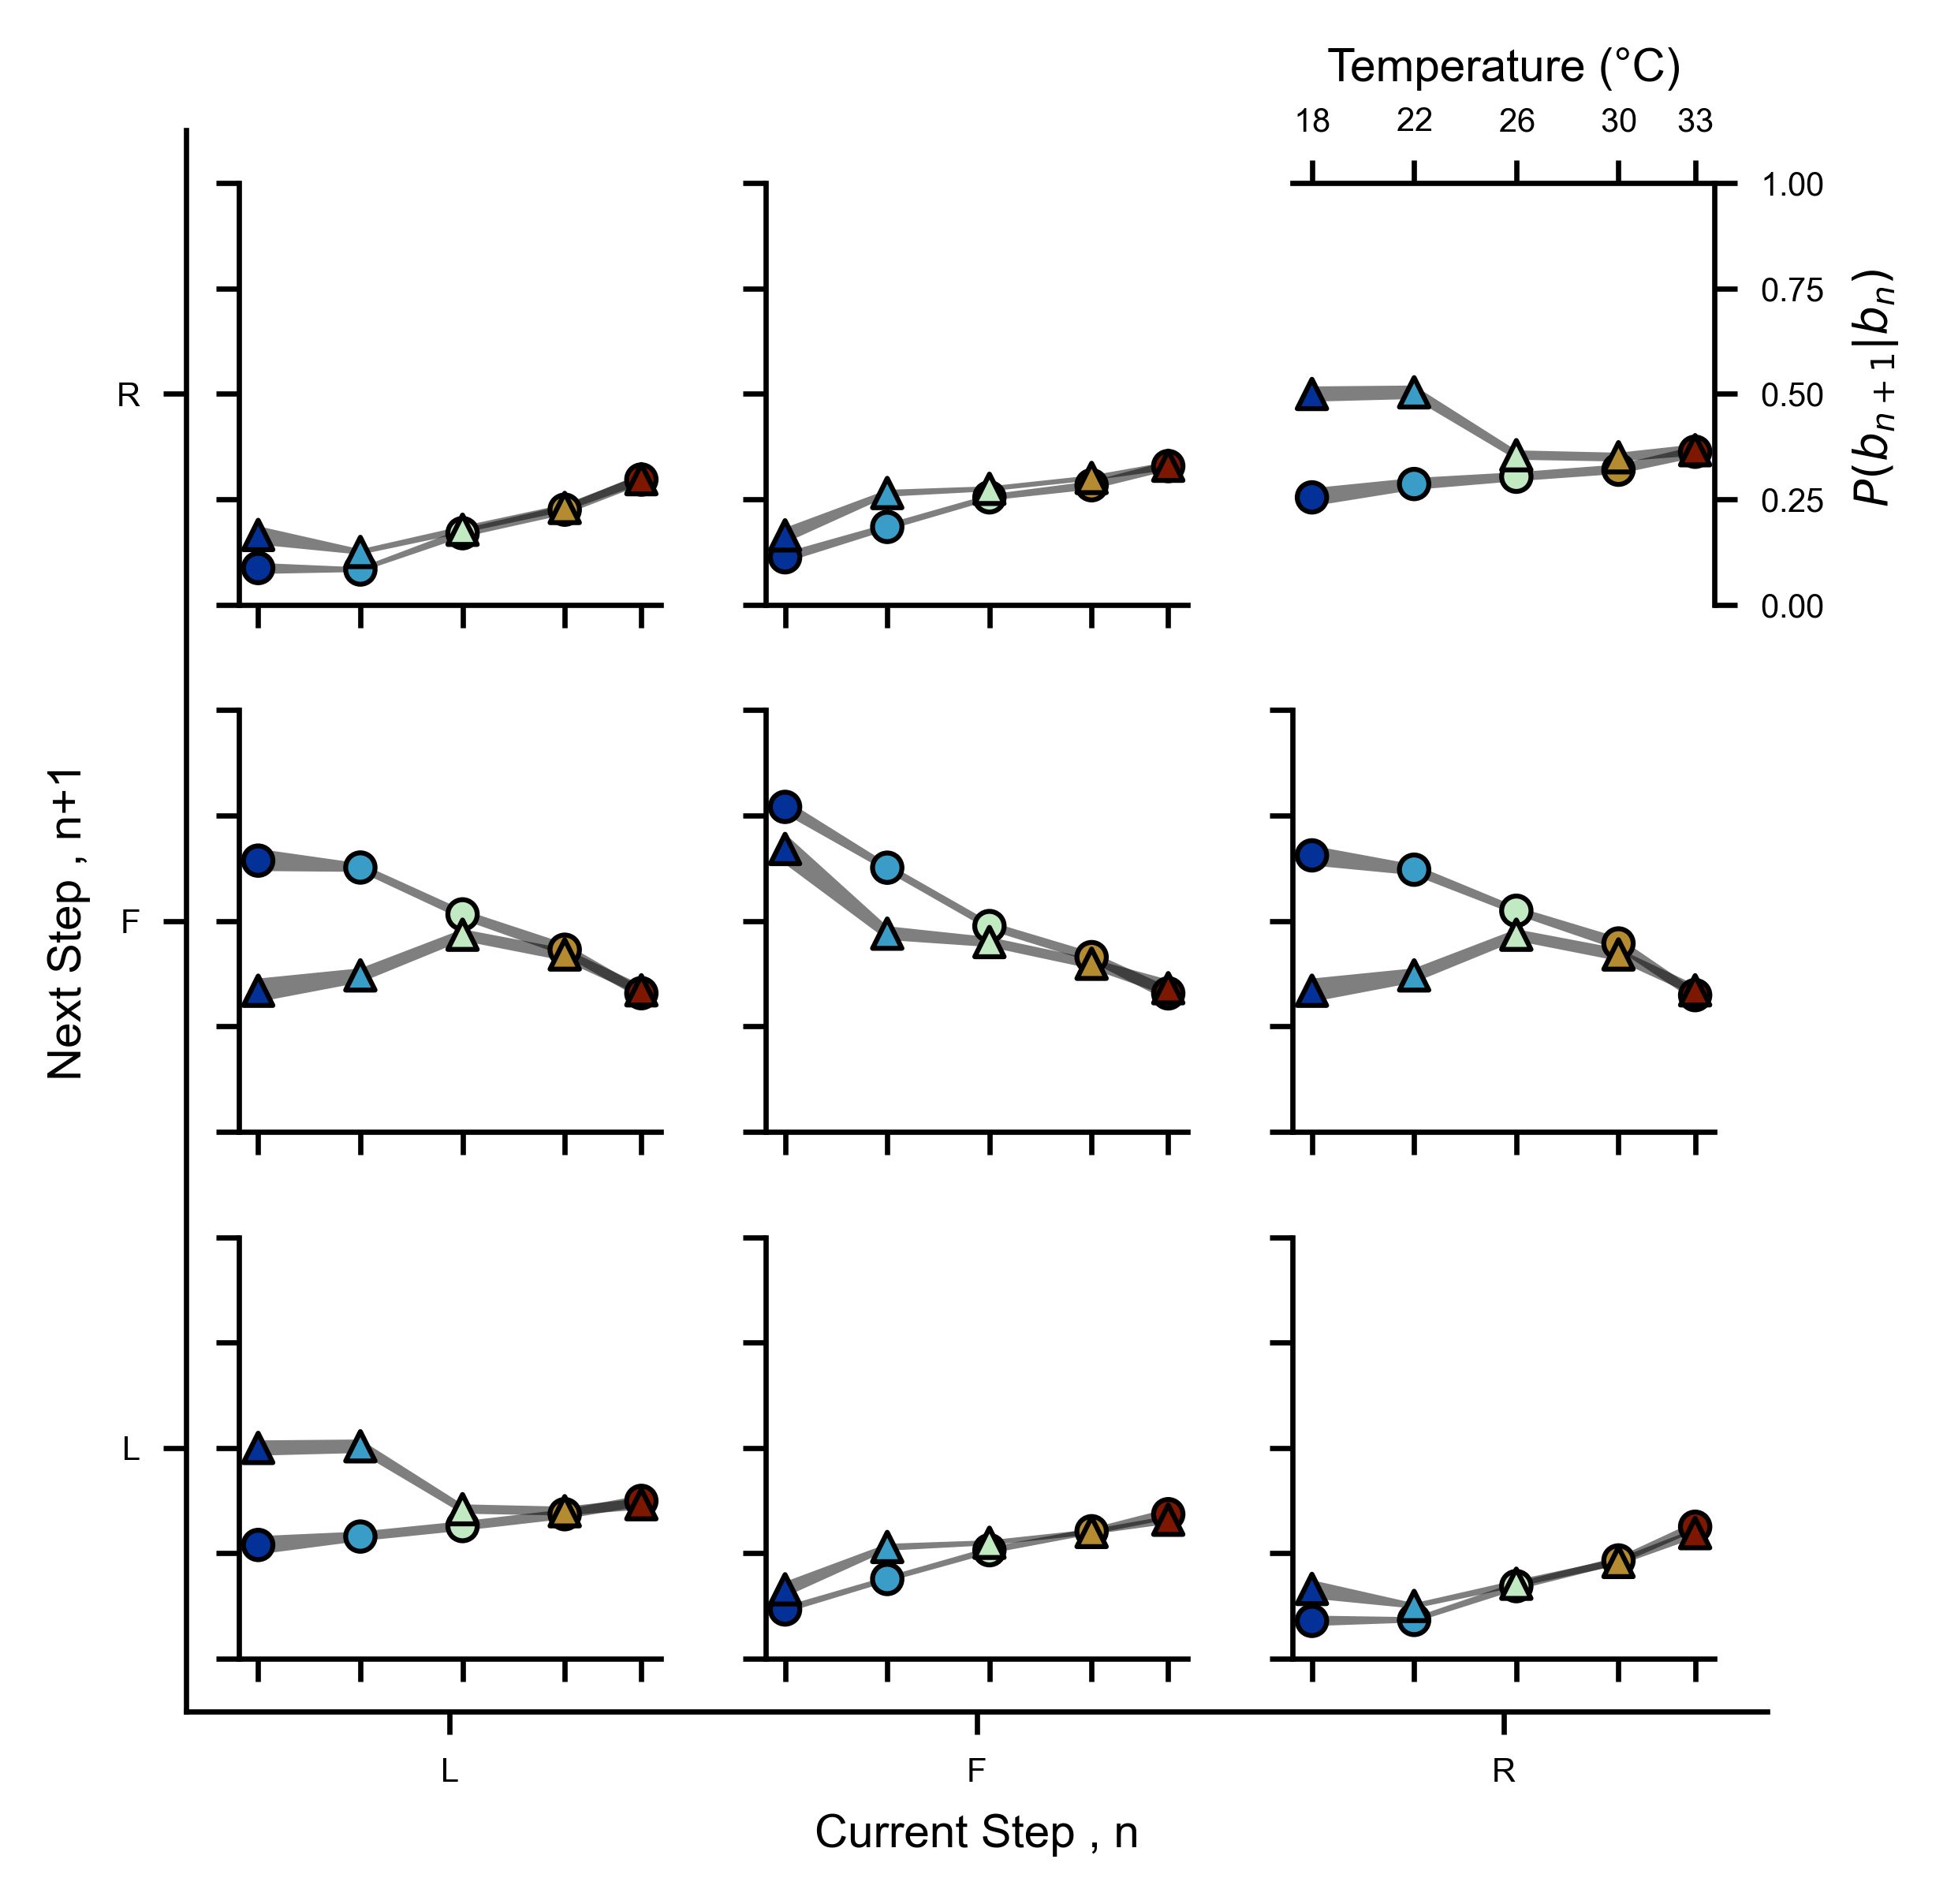

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
pticks = np.linspace(0,1,5)
cols = list(TEMPS_COLS.values())
def center_f(a):
    if a == 0:
        return 1
    elif a == 1:
        return 0
    else:
        return a
        
for i in range(3):
    for j in range(3):
        axin = ax.inset_axes([center_f(i)-0.4, center_f(j)-0.4, 0.8, 0.8], transform=ax.transData)
        axin.set_xticks(TEMPS)
        axin.set_yticks(pticks)
        if (i,j) != (2,2):
            axin.set_xticklabels([])
            axin.set_yticklabels([])
        else:
            axin.set_xlabel("Temperature (°C)")
            axin.set_ylabel(r" $P(b_{n+1}|b_{n})$")
            axin.yaxis.tick_right()
            axin.yaxis.set_label_position("right")
            axin.spines['right'].set_visible(True)
            axin.spines['left'].set_visible(False)
            axin.xaxis.tick_top()
            axin.xaxis.set_label_position("top")
            axin.spines['top'].set_visible(True)
            axin.spines['bottom'].set_visible(False)
        axin.set_ylim(0,1)
        axin.scatter(TEMPS, T_mc[:,i,j,0],c=cols, s=20, edgecolor="black", marker="o", linewidth=0.75, zorder=100)
        axin.fill_between(TEMPS, T_mc[:,i,j,1]+T_mc[:,i,j,2], T_mc[:,i,j,1]-T_mc[:,i,j,2], alpha=0.5, zorder=0, color="k", edgecolor=None)
        axin.scatter(TEMPS, T_hmm[:,i,j,0],c=cols, s=20, edgecolor="black", marker="^", linewidth=0.75, zorder=100)
        axin.fill_between(TEMPS, T_hmm[:,i,j,1]+T_hmm[:,i,j,2], T_hmm[:,i,j,1]-T_hmm[:,i,j,2], alpha=0.5, zorder=0, color="k", edgecolor=None)
        
ax.set_xticks([0,1,2], ["L", "F", "R"])
ax.set_yticks([0,1,2], ["L", "F", "R"])
ax.set_xlabel("Current Step , n")
ax.set_ylabel("Next Step , n+1")
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
ax.set_aspect("equal")

fig.savefig("panels/Fig3/T.svg")

# Supplementaries

## all transition matrices

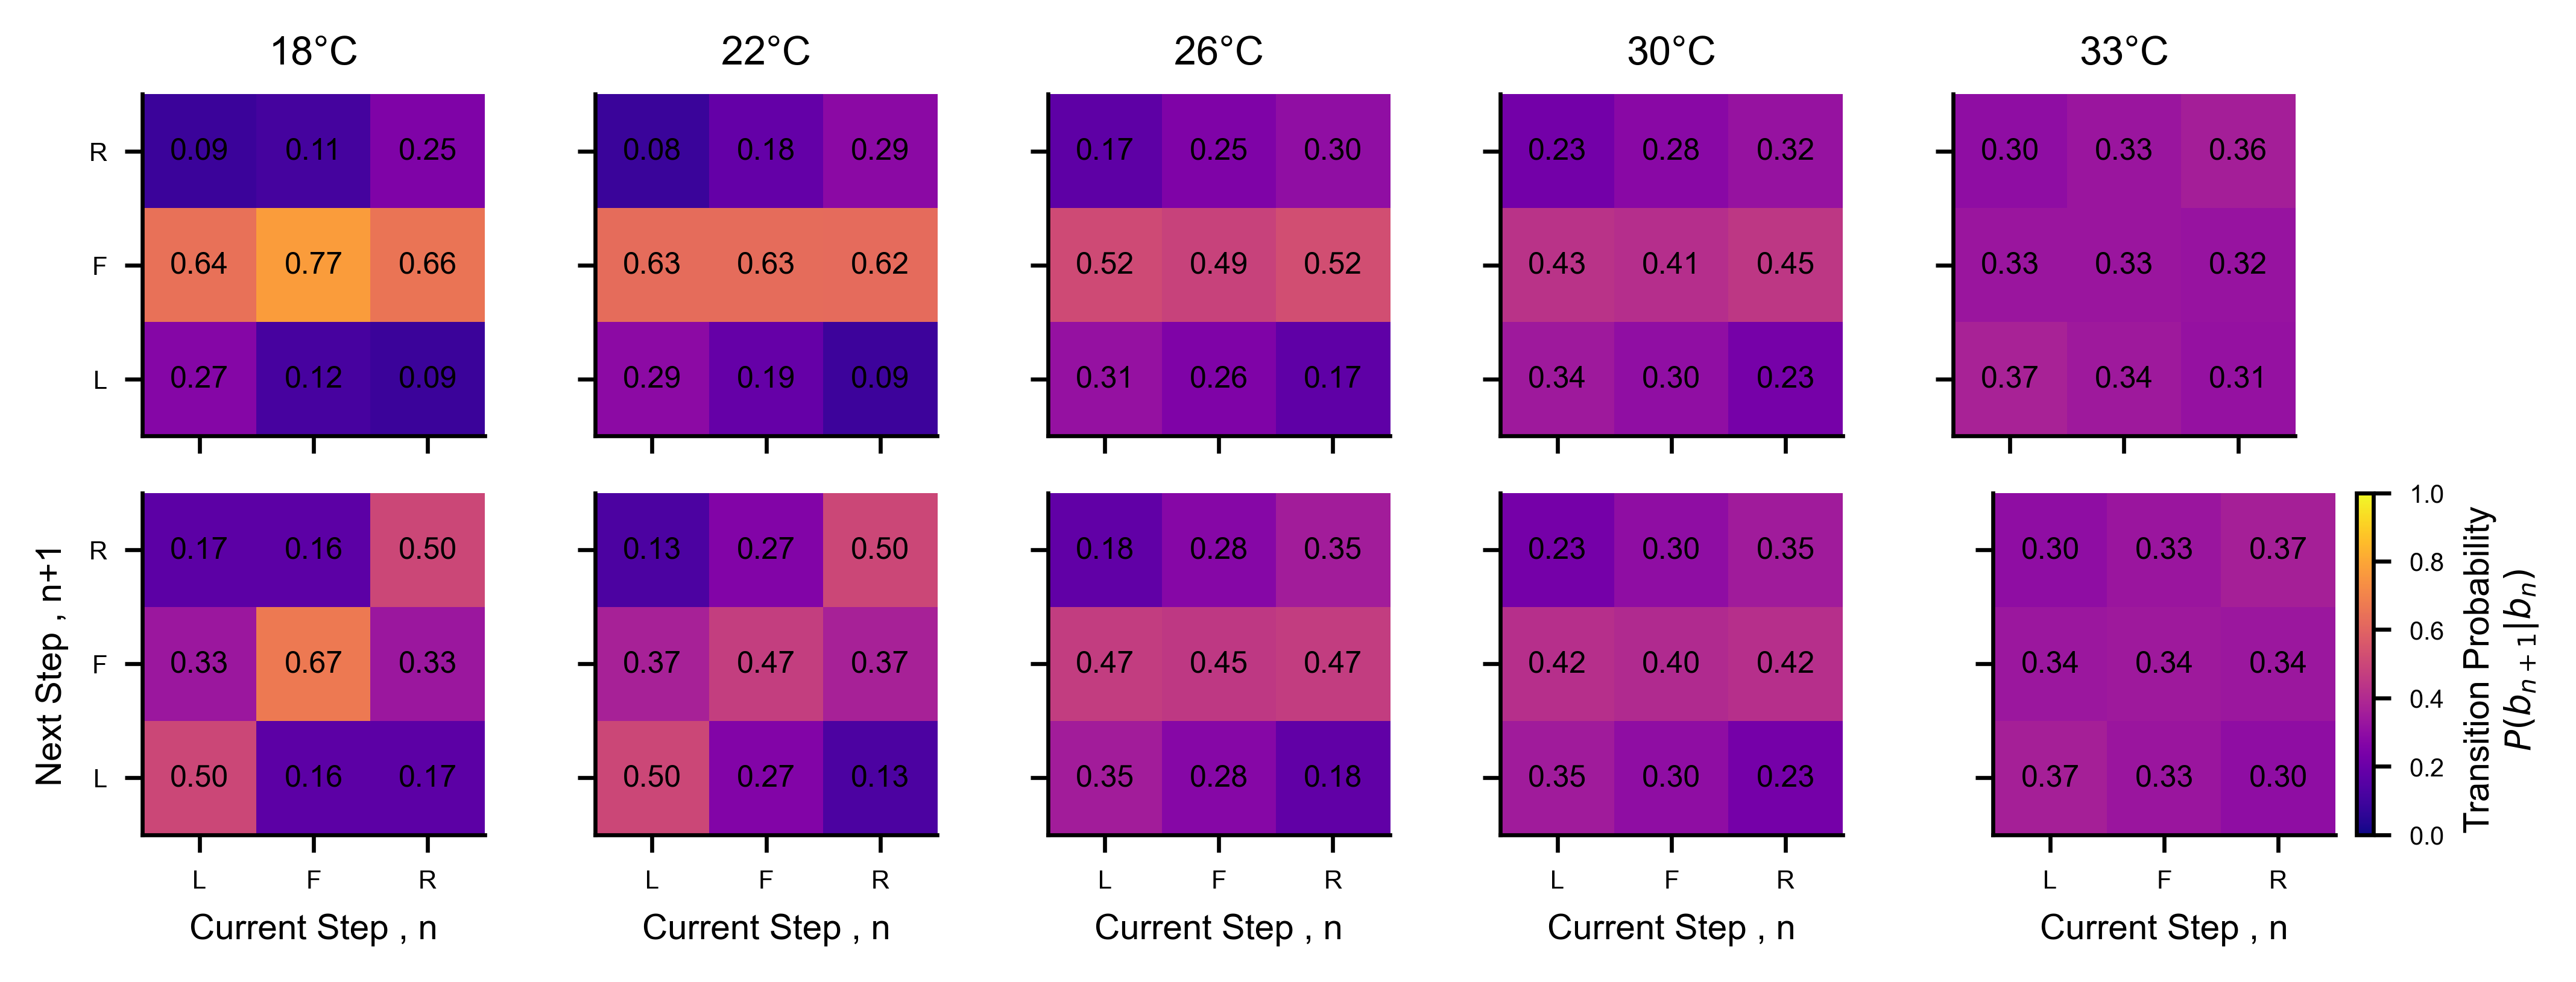

In [3]:
fig, axs = plt.subplots(nrows=2, ncols = len(TEMPS), figsize=(len(TEMPS)*1.4, 1.4 + 1.2), sharex=True, sharey=True)

for i, temp in enumerate(TEMPS):
    ax = axs[0,i]
    ax.set_title(f"{temp}°C")
    #X = file[f"/behaviour/{temp}/dtheta"][:]
    #X = format_sequences(X)
    X = load_sequences(DATAPATH, temp)
    bouts = MC.threshold_classifier(X, -DTHETA_THRESH, +DTHETA_THRESH)
    T = MC.bout_transitions(bouts, n_state=3)
    h = MC.plot_transition_matrix(ax, T[[1,0,2],:][:,[1,0,2]], labels=["L","F","R"], xlabel="Current Step , n", ylabel="Next Step , n+1")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axs[1,i]
    T = load_transmat(MODELPATH, "g3", temp)
    h = MC.plot_transition_matrix(ax, T[[1,0,2],:][:,[1,0,2]], labels=["L","F","R"], xlabel="Current Step , n", ylabel="Next Step , n+1")
    if i > 0:
        ax.set_ylabel("")

fig.colorbar(h, ax=ax, label="Transition Probability \n"+r" $P(b_{n+1}|b_{n})$")

fig.savefig("panels/Fig3/supps/transitions_matrices.svg")

## Emission parameters

In [3]:
E_hmm = np.empty( (len(TEMPS), 3, 3) ) # ( temp x param x [alldataset, mean, std.err.mean] )
for t, temp in enumerate(TEMPS):
    E = load_emission(MODELPATH, "g3", temp)
    E_hmm[t,0,0] = E["forward"]
    E_hmm[t,1:,0] = E["turn"]
    
    Es = load_emission_multi(MODELPATH, "g3", temp)
    E_hmm[t,0,1] = Es["forward"].mean(axis=0)
    E_hmm[t,1:,1] = Es["turn"].mean(axis=0)
    E_hmm[t,0,2] = Es["forward"].ptp(axis=0)/2
    E_hmm[t,1:,2] = Es["turn"].ptp(axis=0)/2

/tmp/ipykernel_16257/2971476860.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hmm[t,0,0] = E["forward"]
/tmp/ipykernel_16257/2971476860.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hmm[t,0,1] = Es["forward"].mean(axis=0)
/tmp/ipykernel_16257/2971476860.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E_hmm[t,0,2] = Es["forward"].ptp(axis=0)/2


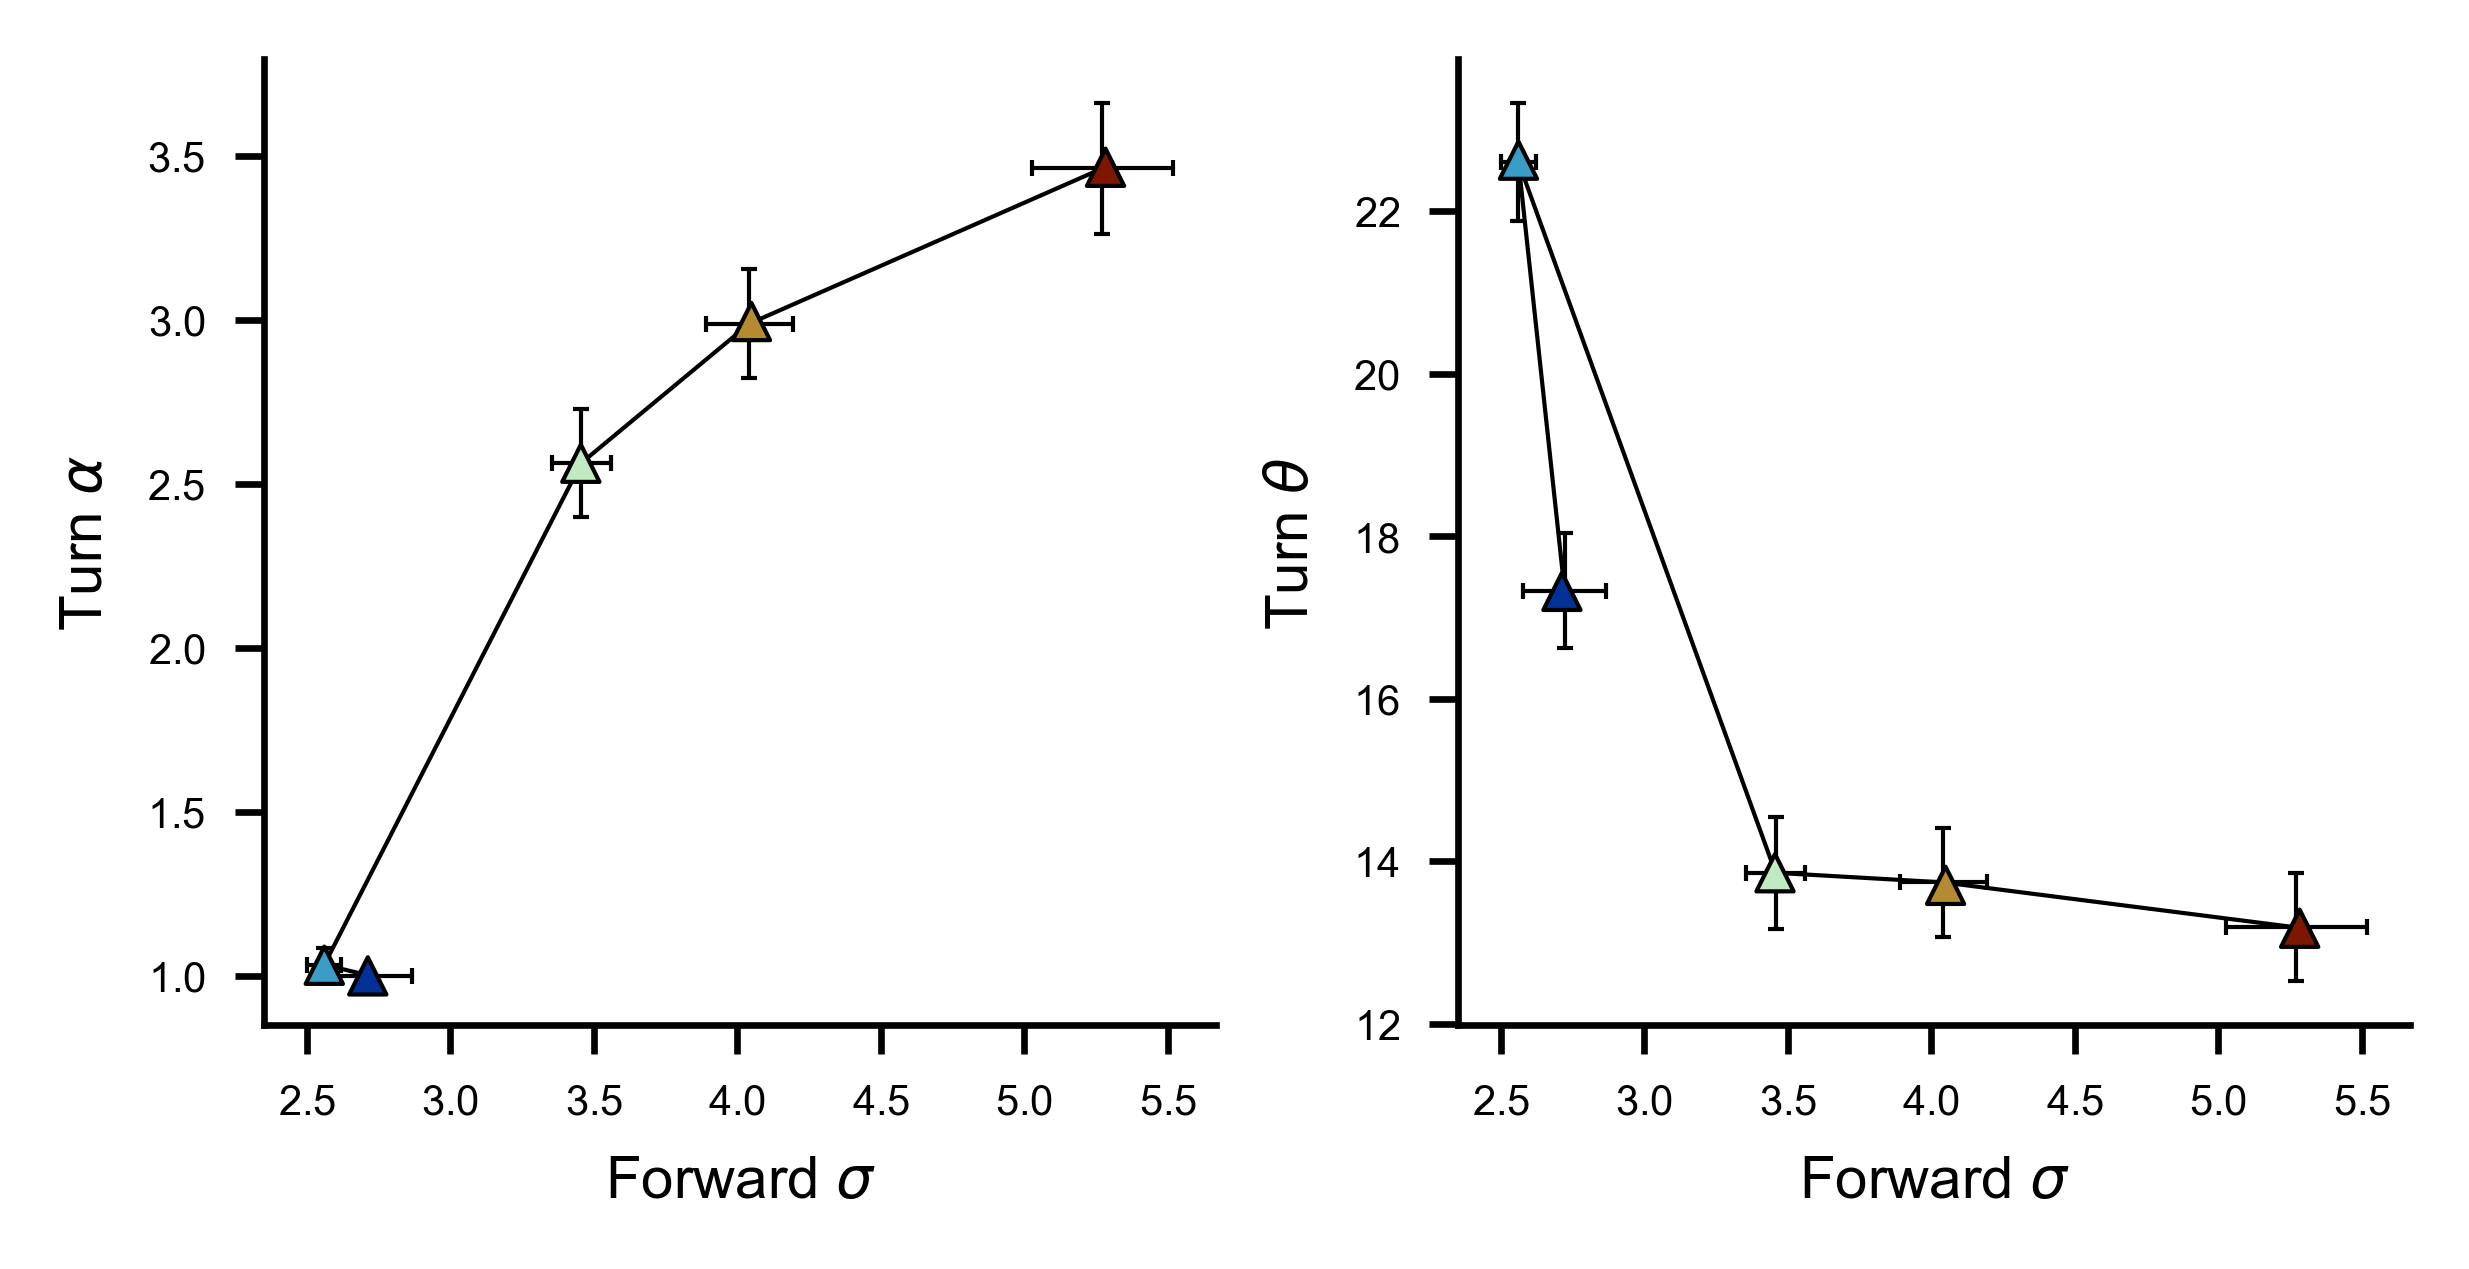

In [4]:
cols = list(TEMPS_COLS.values())

fig, axs = plt.subplots(ncols=2, figsize=(2*2,2))

ax = axs[0]
ax.scatter(E_hmm[:,0,0], E_hmm[:,1,0], c=cols,marker="^", s=20, edgecolor="black", linewidth=0.5, zorder=100)
ax.errorbar(E_hmm[:,0,1], E_hmm[:,1,1], xerr=E_hmm[:,0,2], yerr=E_hmm[:,1,2],markersize=1, capsize=1, linewidth=0.5, capthick=0.5)
ax.set_xlabel(r"Forward $\sigma$")
ax.set_ylabel(r"Turn $\alpha$")

ax = axs[1]
ax.scatter(E_hmm[:,0,0], E_hmm[:,2,0], c=cols, s=20, marker="^", edgecolor="black", linewidth=0.5, zorder=100)
ax.errorbar(E_hmm[:,0,1], E_hmm[:,2,1], xerr=E_hmm[:,0,2], yerr=E_hmm[:,2,2],markersize=1, capsize=1, linewidth=0.5, capthick=0.5)
ax.set_xlabel(r"Forward $\sigma$")
ax.set_ylabel(r"Turn $\theta$")

fig.savefig("panels/Fig3/supps/params_evolv.svg")

## Labeling distributions

In [9]:
from scipy.stats import gamma, norm

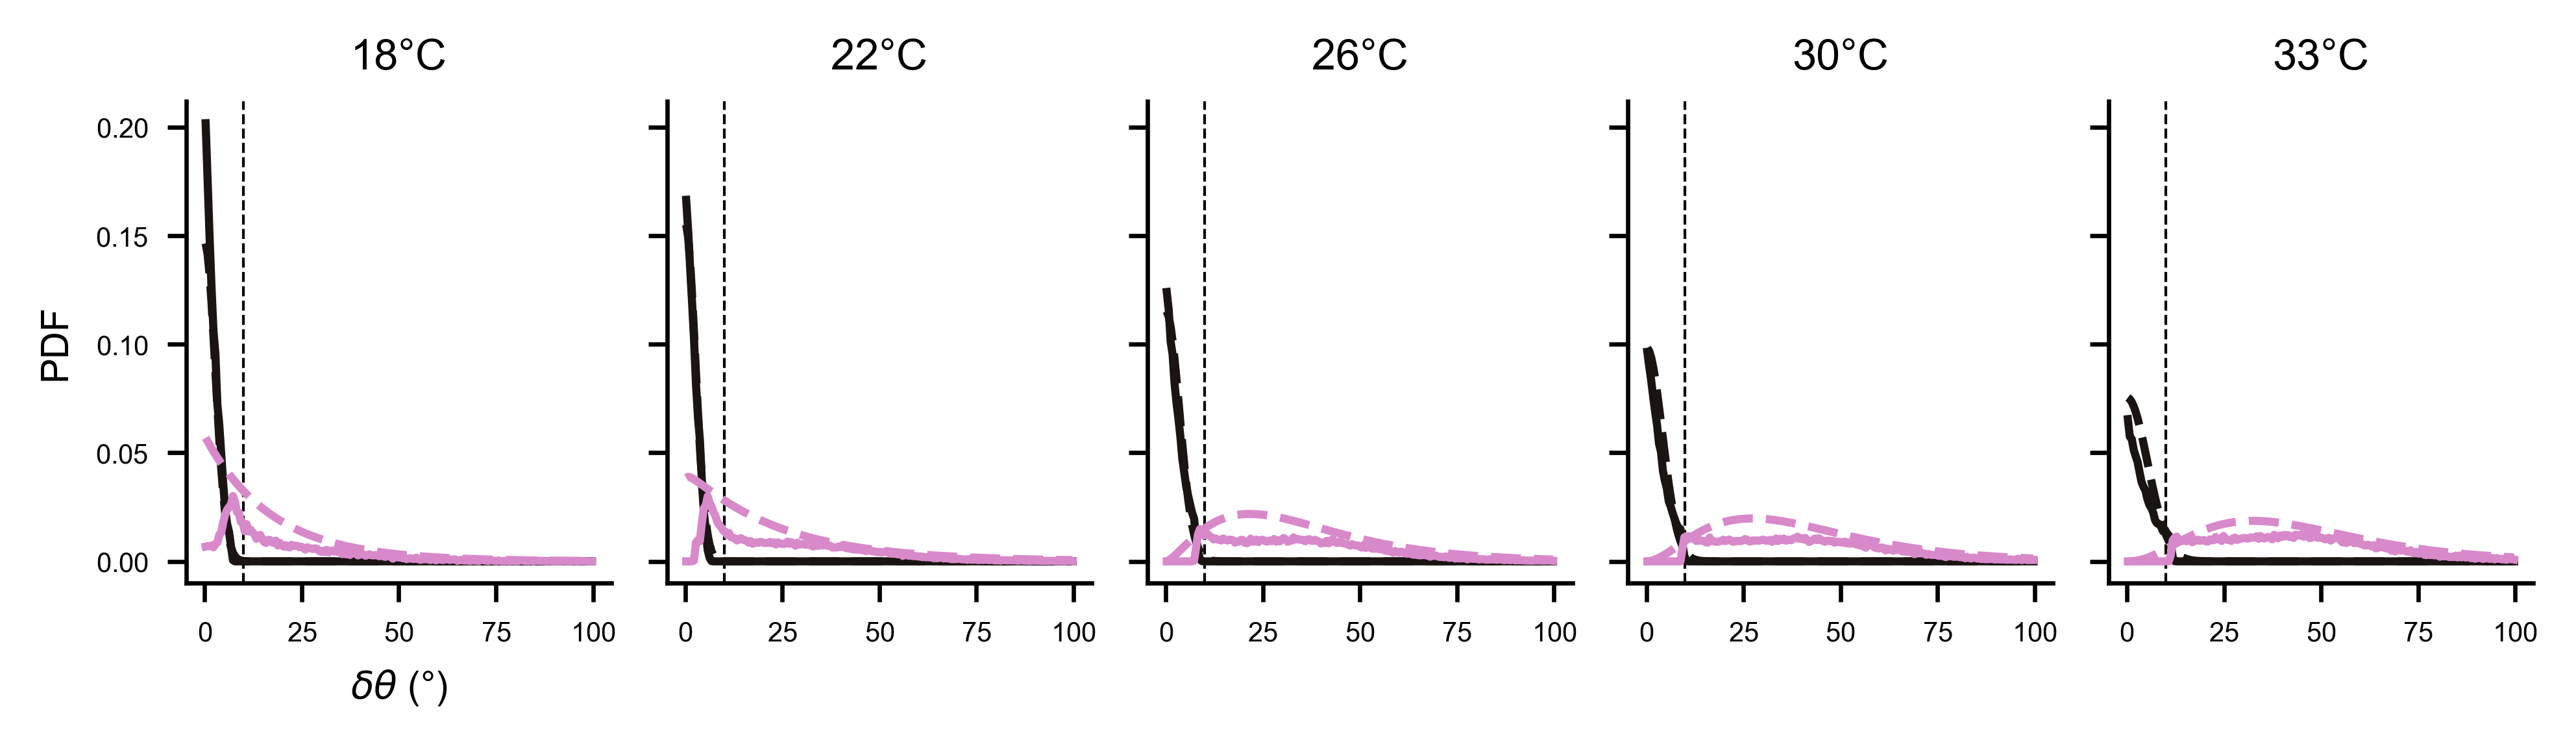

In [11]:
fig, axs = plt.subplots(ncols = len(TEMPS), figsize=(len(TEMPS)*1.3, 1.3 + 0.5), sharex=True, sharey=True)

bins = np.linspace(-0, +100, 200)
db = np.diff(bins).mean()
bin_centers = 0.5*(bins[1:] + bins[:-1])

for ax, temp in zip(axs, TEMPS):
    ax.set_title(f"{temp}°C")
    # get data labeling
    X = load_sequences(DATAPATH, temp)
    X = np.abs(np.concatenate(X))
    bouts_hmm = np.concatenate(load_viterbi(MODELPATH, "g3",temp))
    # get pdfs
    h, _ = np.histogram(X, bins)
    hf, _ = np.histogram(X[np.where(bouts_hmm == 0)[0]], bins)
    ht, _ = np.histogram(X[np.where((bouts_hmm == 1) + (bouts_hmm == 2))[0]], bins)
    nn = hf.sum() + ht.sum()
    hf = hf/nn / db
    ht = ht/nn / db
    h = h/h.sum() / db
    # get the PDFs from the model emissions
    params = load_emission(MODELPATH, "g3", temp)
    F = norm.pdf(bin_centers, 0, params["forward"][0])
    T = gamma.pdf(bin_centers, params["turn"][0], scale=params["turn"][1])
    ax.plot(bin_centers, hf, color=FLR_colors[0], zorder=1)
    ax.plot(bin_centers, F, color=FLR_colors[0], linestyle="--", zorder=2)
    ax.plot(bin_centers, ht, color=FLR_colors[2], zorder=3)
    ax.plot(bin_centers, T, color=FLR_colors[2], linestyle="--", zorder=4)
    ax.axvline(DTHETA_THRESH, linestyle="--", linewidth=0.5, zorder=0)

axs[0].set_xlabel(r"$\delta \theta$ (°)")
axs[0].set_ylabel("PDF")

fig.savefig("panels/Fig3/supps/distrib_labelings.svg")